In [1]:
#import os
#import sys
#import scipy.io
#import scipy.misc

#import pandas as pd
import numpy as np

import scipy

import tensorflow as tf
#import sklearn
#import xgboost

import matplotlib.pyplot as plt

import pprint

#%matplotlib inline

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


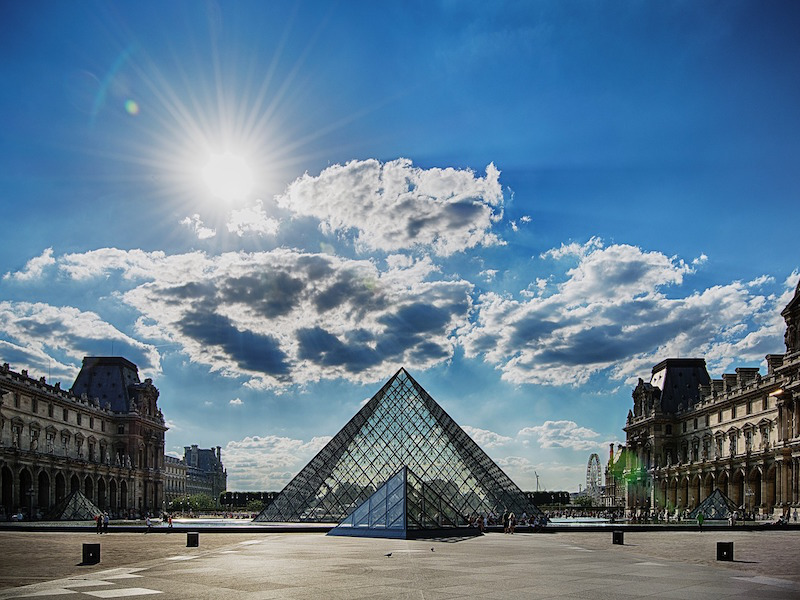

In [2]:
# using this cell to view images
from examples import get_louvre_img, get_claude_monet_img

get_louvre_img()

In [2]:
# Other setup
pp = pprint.PrettyPrinter(indent=4)

# Constants
img_dimensions = (400, 400)

(1, 400, 400, 3)


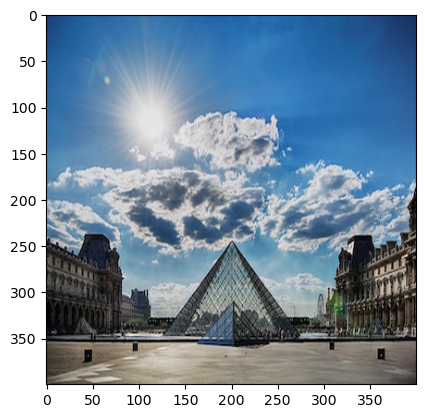

In [4]:
# Load Content Image
from utils import tf_load_img

content_image = tf_load_img("louvre_small.jpg", img_dimensions)

print(content_image.shape)
plt.imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


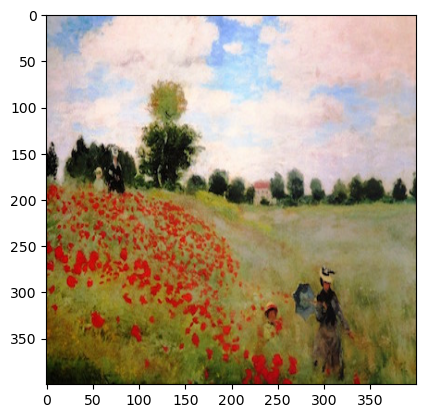

In [5]:
# Load Style Image
style_image = tf_load_img("monet.jpg", img_dimensions)

print(style_image.shape)
plt.imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


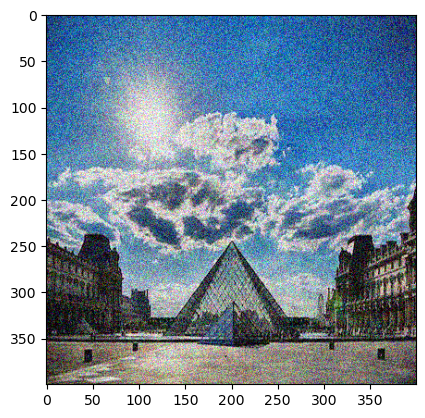

In [6]:
# Randomly initialize image to be generated
from utils import add_uniform_noise

generated_image = add_uniform_noise(content_image, min=-0.25, max=0.25)

print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])
plt.show()

In [7]:
# LOAD PRETRAINED MODEL VGG-19 (Transfer Learning)
# Encoder
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_dimensions[0], img_dimensions[1], 3),
                                  weights="../pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")
vgg.trainable = False

pp.pprint(vgg)

for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [8]:
# Layer Constants
# layers go: (<name: str>, <weight: float>)

content_layer = [('block5_conv4', 1.0)]
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]



ALL_LAYERS_USED = STYLE_LAYERS + content_layer
ALL_LAYER_NAMES = [layer_delegation[0] for layer_delegation in ALL_LAYERS_USED]

# Initialize Encoder
encoder = tf.keras.Model(inputs=[vgg.input], outputs=[vgg.get_layer(layer_name).output for layer_name in ALL_LAYER_NAMES])

# Initialize targets
content_target = encoder(content_image) # Encoded Content
style_targets = encoder(style_image)    # Encoded Style

In [9]:
# Do the same thing (initialize target encodings), but make them variables rather than constants
from preprocessing import preprocess

preprocessed_content = preprocess(content_image)
preprocessed_style = preprocess(style_image)

Epoch 0
J = [[25262.334]]


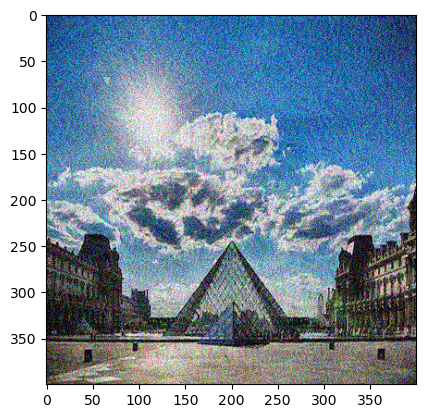

Epoch 250
J = [[14.412271]]


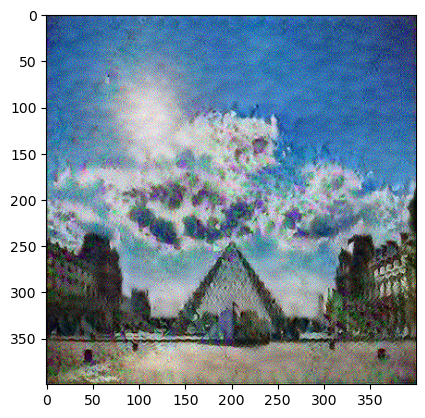

Epoch 500
J = [[6.949093]]


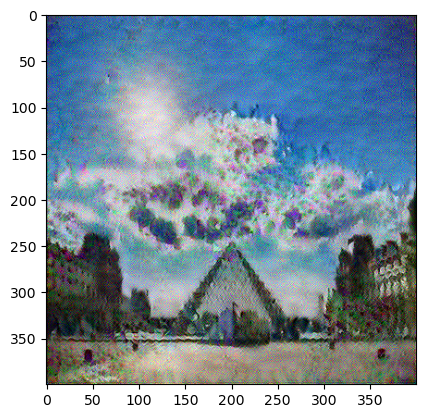

Epoch 750
J = [[5.012068]]


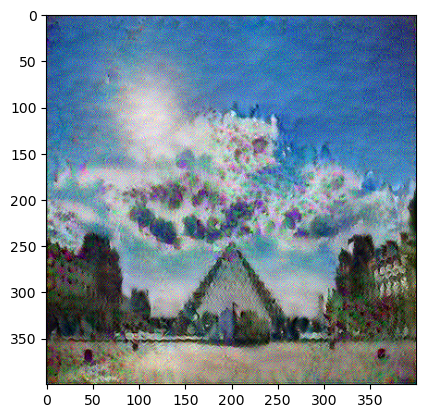

Epoch 1000
J = [[4.0880427]]


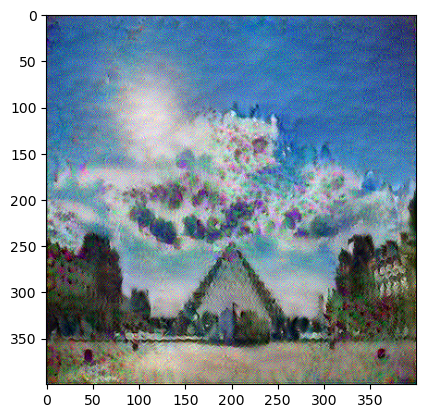

Epoch 1250
J = [[4.697912]]


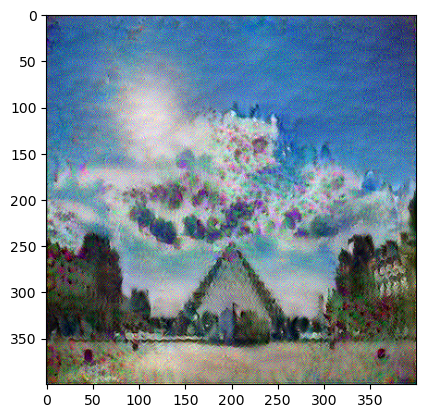

Epoch 1500
J = [[188.99193]]


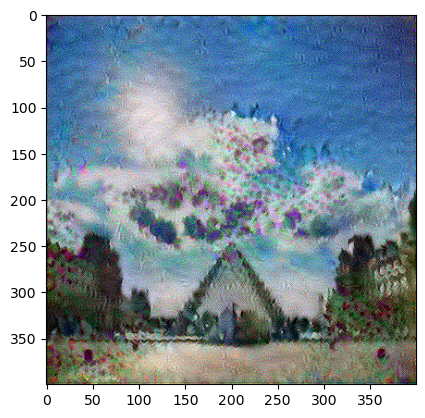

Epoch 1750
J = [[3.9192035]]


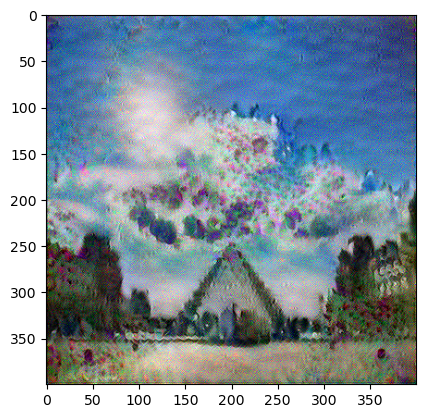

Epoch 2000
J = [[5.4343853]]


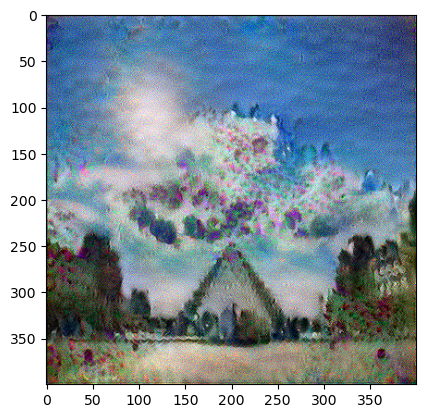

Epoch 2250
J = [[2.682936]]


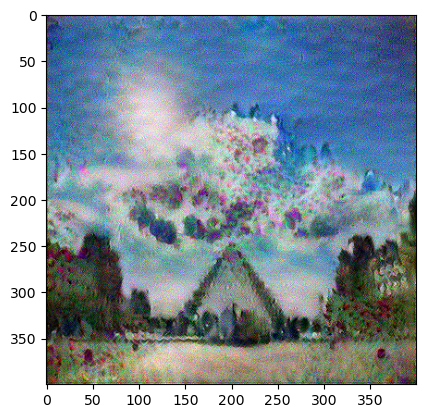

Training Complete.


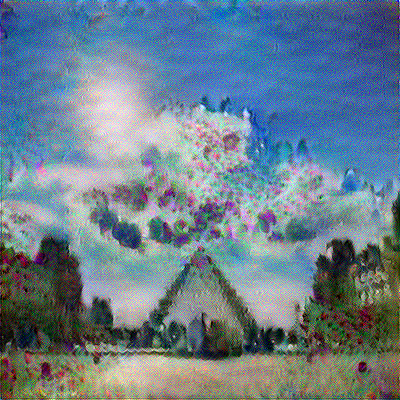

In [12]:
# Neural Style Transfer
from nst.neuralstyletransfer import NeuralStyleTransfer, NstInputs, StyleInputs, NstHyperparameters

nst_inputs = NstInputs(
    content_img=preprocessed_content,
    style=StyleInputs(image=preprocessed_style, layer_delegations=STYLE_LAYERS),
    generated_img=tf.Variable(generated_image))

nst_hyperparameters = NstHyperparameters(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    alpha=10, beta=40)

nst = NeuralStyleTransfer(encode=encoder, nst_inputs=nst_inputs, hyperparameters=nst_hyperparameters)
nst.train(epochs=2500, epoch_interval=250, safe=True)

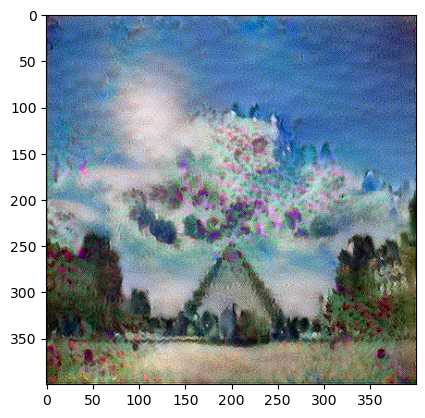

In [16]:
plt.imshow(nst.output_image)
#plt.axis("off")
plt.show()

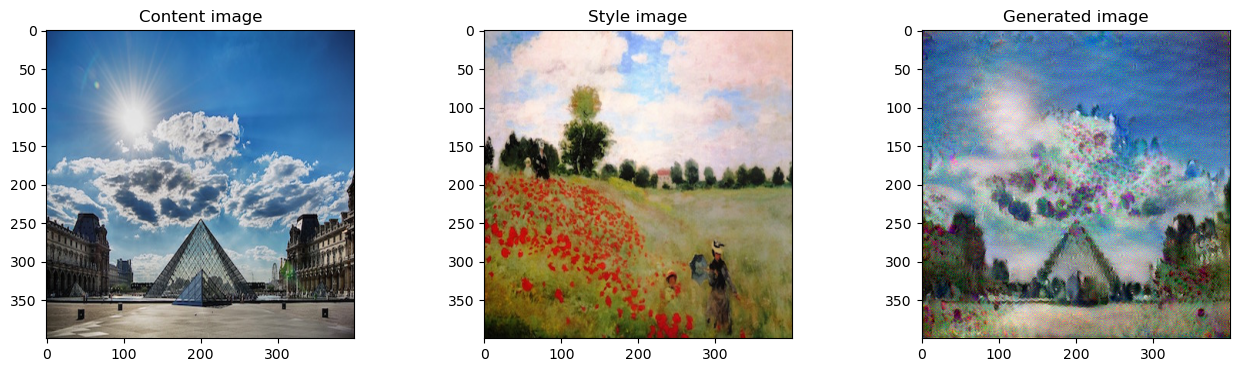

In [14]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
plt.imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
plt.imshow(nst.output_image)
ax.title.set_text('Generated image')
plt.show()

In [17]:
#nst.output_image.save("../out/louvre_monet.jpg")